In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding = 'latin1')

In [4]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
data.shape

(5572, 5)

In [6]:
data.isna().sum().sort_values()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [7]:
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)

In [8]:
data.head(2)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [9]:
data.rename(columns = {'v1': 'sms_label', 'v2':'sms_raw_text'}, inplace = True)

In [10]:
data.head(2)

,sms_label,sms_raw_text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [11]:
spam_prorp = data['sms_label'].value_counts(normalize = True)

In [12]:
spam_prorp

sms_label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

**The dataset is highly imbalanced.Almost 87% are non-spam sms whereas the remaining 13% are classified as spams sms**

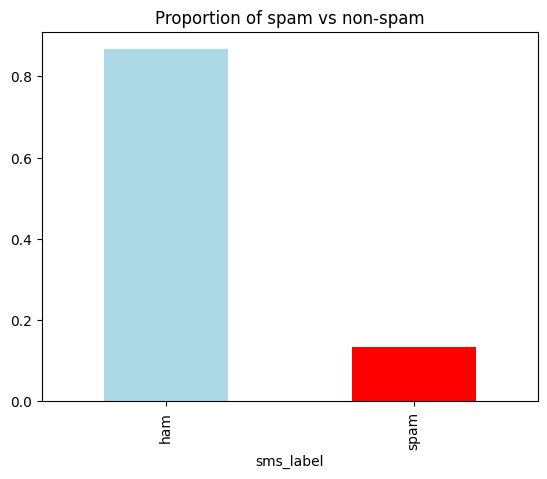

In [13]:
spam_prorp.plot(x = spam_prorp.index, y = spam_prorp.values, kind = 'bar', 
                color = ['lightblue' if label == 'ham' else 'red' for label in spam_prorp.index],
               title = 'Proportion of spam vs non-spam')
plt.show()

In [14]:
data['sms_raw_text'][:5]

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: sms_raw_text, dtype: object

In [15]:
# Let's encode the target variable (1 for spam and 0 for ham or legitimate)
label_mapping = {'ham':0, 'spam':1}
data['sms_label'].replace(label_mapping, inplace = True)

In [16]:
data.head()

,sms_label,sms_raw_text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
# Let's import Dataset, DataLoader, DistilBert (developped by HuggingFace) and...
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [18]:
# Let's train_test_split the data
train_data, eval_data = train_test_split(data, test_size = 0.2, random_state = 42, stratify = data['sms_label'])

In [19]:
train_data

,sms_label,sms_raw_text
184,0,Going on nothing great.bye
2171,0,I wont. So wat's wit the guys
5422,0,Ok k..sry i knw 2 siva..tats y i askd..
4113,0,Where are you ? What do you do ? How can you s...
4588,0,Have you not finished work yet or something?
...,...,...
1932,0,Jus finished avatar nigro
5316,0,Jus finish watching tv... U?
2308,1,Moby Pub Quiz.Win a å£100 High Street prize if...
1903,1,Free entry in 2 a weekly comp for a chance to ...


In [20]:
eval_data

,sms_label,sms_raw_text
2826,0,"Oh right, ok. I'll make sure that i do loads o..."
3695,0,I am in tirupur. call you da.
3906,0,No that just means you have a fat head
575,1,"You have won ?1,000 cash or a ?2,000 prize! To..."
2899,0,Come aftr &lt;DECIMAL&gt; ..now i m cleaning ...
...,...,...
854,0,Stop the story. I've told him i've returned it...
5044,0,We have sent JD for Customer Service cum Accou...
2015,0,Just re read it and I have no shame but tell m...
3381,0,"Well, I meant as opposed to my drunken night o..."


In [21]:
# Let's define pytorch Dataset
class SpamDetectionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = 256

    def __len__(self) :
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['sms_raw_text']
        labels = self.data.iloc[idx][['sms_label']].values.astype(int)
        # padding set to 'max_length ensures that all tokenized text with length<max_length will complete to zero'
        # truncation set to True ensures no tokenized text will exceed max_length
        encoding = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)

        input_ids = encoding['input_ids'][0] # Almost the same as encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'][0]
       
        return input_ids, attention_mask, torch.tensor(labels)
        

In [22]:
# Now, let's define the DistilBert tokenizer and transform our train_data, eval_data in Pytorch Dataset
model_checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = DistilBertTokenizer.from_pretrained(model_checkpoint)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

In [23]:
train_dataset = SpamDetectionDataset(train_data, tokenizer)
eval_dataset = SpamDetectionDataset(eval_data, tokenizer)

In [24]:
next(iter(train_dataset))

(tensor([ 101, 2183, 2006, 2498, 2307, 1012, 9061,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [25]:
batch_size = 20
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

In [26]:
class DistilBertClassifier(nn.Module): 
    def __init__(self, num_labels):
        super().__init__()
        self.distilbert = DistilBertForSequenceClassification.from_pretrained(model_checkpoint,
                                                                             num_labels = num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)

        return outputs.logits
        
        

In [27]:
# Now it's timee to train the model
num_labels = 2
model = DistilBertClassifier(num_labels).to(device) # we turn the model to cpu or gpu
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [28]:
from torchmetrics import Accuracy
accuracy= Accuracy(task = 'binary')

In [29]:
accuracy.to(device)

BinaryAccuracy()

In [30]:
model

DistilBertClassifier(
  (distilbert): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [31]:
def train_eval(model, optimizer, loss_fn, train_loader, test_loader, epochs = 2) :
    list_train_loss = []
    list_test_loss = []
    train_accuracy = []
    test_accuracy = []
    
    for epoch in range(epochs) :
        train_loss = 0
        test_loss = 0
        model.train()

        for batch in  train_loader :
            optimizer.zero_grad()
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.view(-1) # we reshape the label to map the model output
            labels = labels.to(device)
            
            # run forward pass and compute loss
            logits = model(input_ids, attention_mask)
            loss = loss_fn(logits, labels)
            predicted_label = nn.functional.sigmoid(logits)
            _, predicted_label = torch.max(predicted_label, 1)
            accuracy(predicted_label, labels)
            # compute gradient
            loss.backward()
            #update model parameters (back_propagation)
            optimizer.step()
            train_loss += loss.item()
            
        # final loss    
        train_loss = train_loss/len(train_loader)
        list_train_loss.append(train_loss)
        train_acc = accuracy.compute()
        train_accuracy.append(train_acc.item())
        accuracy.reset()
        
        print('Epoch {} loss on train set is: -----> {} and acc is: ----> {}'.format(epoch+1, train_loss, train_acc))
        print('-----------------------------------------------------------------------')

        model.eval() 
        with torch.no_grad() :
            for batch in test_loader: 
                eval_input_ids, eval_attention_mask, eval_labels = batch
                eval_input_ids = eval_input_ids.to(device)
                eval_attention_mask = eval_attention_mask.to(device)
                eval_labels = eval_labels.view(-1) # we reshape the label to map the model output
                eval_labels = eval_labels.to(device)

                eval_logits = model(eval_input_ids, eval_attention_mask)
                eval_loss = loss_fn(eval_logits, eval_labels)
                test_loss += eval_loss.item()

                eval_pred_label = nn.functional.sigmoid(eval_logits)
                _, eval_pred_label = torch.max(eval_pred_label, 1)
                accuracy(eval_pred_label, eval_labels)

            #final test_loss
            test_loss /= len(test_loader)
            list_test_loss.append(test_loss)
            val_acc = accuracy.compute()
            test_accuracy.append(val_acc.item())
            accuracy.reset()

            print('Epoch {} loss on eval set is: -----> {} and acc is: ---->{}'.format(epoch+1, test_loss, val_acc))
            print('=====================================================================')

                

    return list_train_loss, list_test_loss, train_accuracy, test_accuracy


In [32]:
result = train_eval(model, optimizer, criterion, train_dataloader, eval_dataloader)

Epoch 1 loss on train set is: -----> 0.18581230601717638 and acc is: ----> 0.939645528793335
-----------------------------------------------------------------------
Epoch 1 loss on eval set is: -----> 0.04106280812785761 and acc is: ---->0.9901345372200012
Epoch 2 loss on train set is: -----> 0.02988741252176681 and acc is: ----> 0.9914740920066833
-----------------------------------------------------------------------
Epoch 2 loss on eval set is: -----> 0.0406585737010963 and acc is: ---->0.9910314083099365


In [33]:
list_train_loss, list_test_loss, train_accuracy, test_accuracy = result

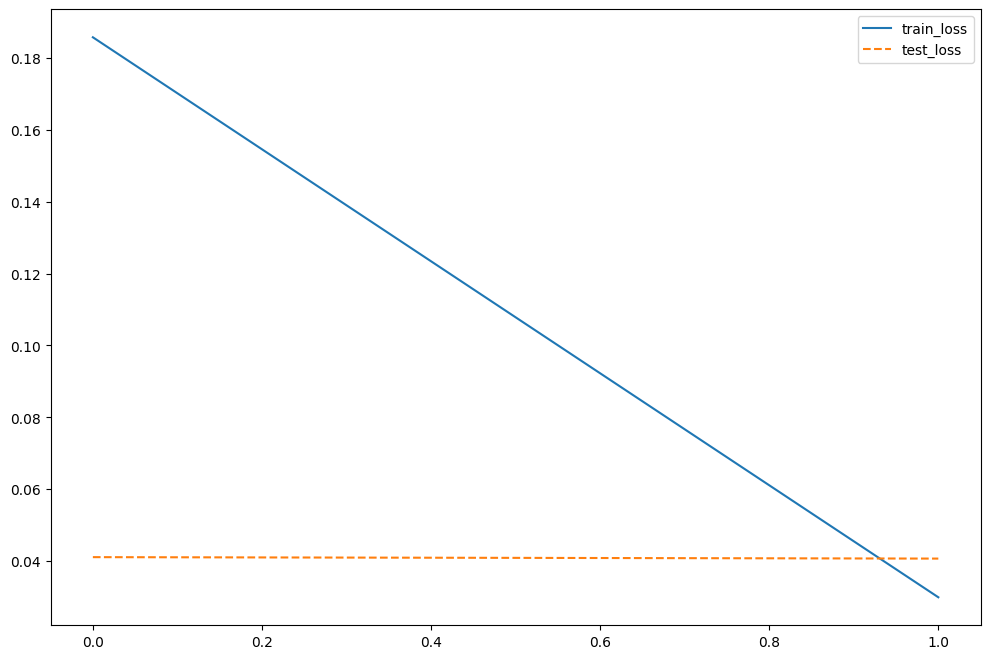

In [34]:
plt.figure(figsize = (12, 8))
plt.plot(list_train_loss, label = 'train_loss')
plt.plot(list_test_loss, label = 'test_loss', linestyle = '--')
plt.legend()
plt.show()

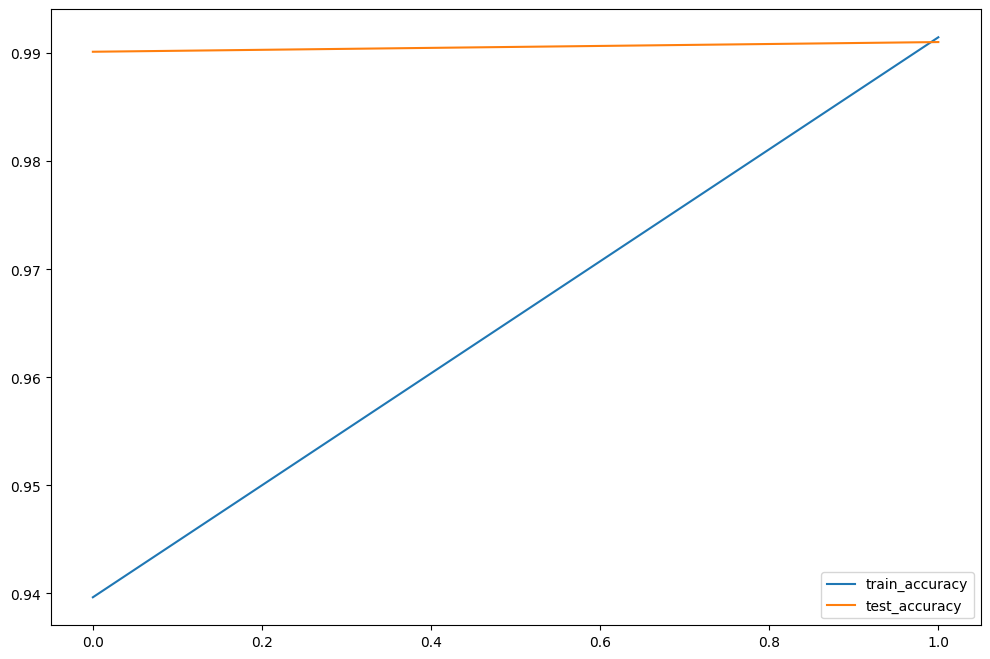

In [35]:
plt.figure(figsize = (12, 8))
plt.plot(train_accuracy, label = 'train_accuracy')
plt.plot(test_accuracy, label = 'test_accuracy')
plt.legend()
plt.show()

In [36]:
# Let's visualize, confusion matrix, and auc_roc_score
all_labels = []
all_preds = []

with torch.no_grad():
    
    n_correct = 0
    n_samples = 0
    for batch in eval_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)

        attention_mask = attention_mask.to(device)

        labels = labels.view(-1)
        labels = labels.to(device)

        logits = model(input_ids, attention_mask)
        
        eval_pred_label = nn.functional.sigmoid(logits)
      
        _, predictions = torch.max(eval_pred_label, 1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(predictions.cpu().numpy())

In [37]:
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

In [38]:
all_labels

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
all_preds

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
len(list(filter(lambda x: x==1, all_labels)))/len(all_labels)

0.1336322869955157

In [41]:
len(list(filter(lambda x: x==1, all_preds)))/len(all_preds)

0.12645739910313902

In [42]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.99      0.94      0.97       149

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [43]:
from sklearn.metrics import accuracy_score

In [44]:
print(accuracy_score(all_labels, all_preds))

0.9910313901345291


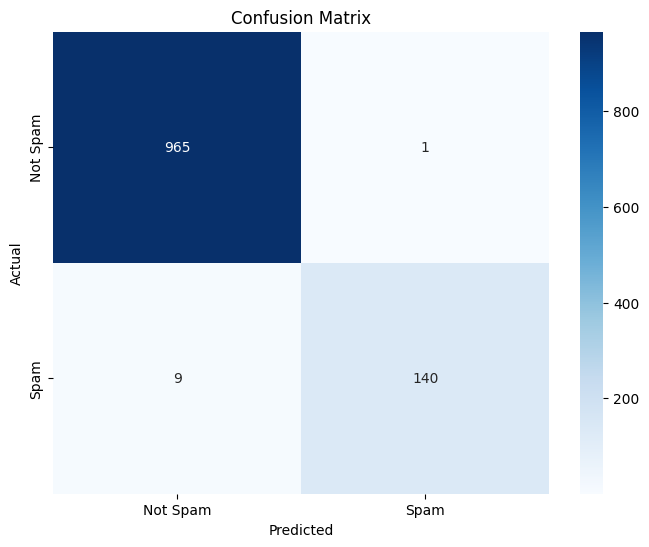

In [47]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import os

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [49]:
# Save model and tokenizer for Hugging Face deployment
output_dir = "distilbert_spam_model"
os.makedirs(output_dir, exist_ok=True)

# Save PyTorch model
torch.save(model.state_dict(), os.path.join(output_dir, "model.pth"))

# Save tokenizer if applicable
if hasattr(tokenizer, 'save_pretrained'):
    tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer (if applicable) saved in {output_dir}")

Model and tokenizer (if applicable) saved in distilbert_spam_model
